How to translate with and without attention

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Languages: https://www.manythings.org/anki/

How to invert a given sequence (read but not implemented)

https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
import unicodedata
import re
import random

In [2]:
# Check CUDA
print("Using CUDA: {}".format(torch.cuda.is_available()))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BS = 128

print(torch.__version__)
#Pytorch version 1.0.1 doesn't seem to work

Using CUDA: True
1.0.0


In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) #adds a space before these characters
    s = re.sub(r"[^a-zA-Z.!?α-ωΑ-Ω]+", r" ", s) #handle Greek characters
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('d:/data/Language pairs/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ", "i'm",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        #p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ell', False)
if len(pairs)>0:
    print(random.choice(pairs))

Reading lines...
Read 15931 sentence pairs
Trimmed to 14583 sentence pairs
Counting words...
Counted words:
eng 2992
ell 5778
['what time does the store open ?', 'τι ωρα ανοιγει το καταστημα ', 'cc by . france attribution tatoeba .org ck glavkos ']


In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=DEVICE).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=DEVICE)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, None #Return None to make it compatible with Attention Decoder (return output, hidden, attn_weights)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
#Luong Attention
#https://blog.floydhub.com/attention-mechanism/
class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        # The Attention Mechanism is defined in a separate class
        self.attention = attention

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        
        #self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        self.classifier = nn.Linear(self.hidden_size*2, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        # Embed input words
        embedded = self.embedding(inputs).view(1,1,-1)
        embedded = self.dropout(embedded)

        # Passing previous output word (embedded) and hidden state into LSTM cell
        #lstm_out, hidden = self.lstm(embedded, hidden)
        gru_out, hidden = self.gru(embedded, hidden)

        # Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(gru_out, encoder_outputs)
        # Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        # Multiplying Attention weights with encoder outputs to get context vector
        #Stavros added: .unsqueeze(0) to encoder_outputs
        context_vector = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        # Concatenating output from LSTM with context vector
        output = torch.cat((gru_out, context_vector),-1)
        # Pass concatenated vector through Linear layer acting as a Classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights
  
class Attention(nn.Module):
    def __init__(self, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        # Defining the layers/weights required depending on alignment scoring method
        if method == "general":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)

        elif method == "concat":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
  
    def forward(self, decoder_hidden, encoder_outputs):
        if self.method == "dot":
            # For the dot scoring method, no weights or linear layers are involved
            return encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)

        elif self.method == "general":
            # For general scoring, decoder hidden state is passed through linear layers to introduce a weight matrix
            out = self.fc(decoder_hidden)
            return encoder_outputs.bmm(out.view(1,-1,1)).squeeze(-1)
    
        elif self.method == "concat":
            # For concat scoring, decoder hidden state and encoder outputs are concatenated first
            out = torch.tanh(self.fc(decoder_hidden+encoder_outputs))
            return out.bmm(self.weight.unsqueeze(-1)).squeeze(-1)

In [13]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=DEVICE)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    encoder.train()
    decoder.train()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

5m 1s (- 70m 26s) (5000 6%) 4.0093
8m 40s (- 56m 25s) (10000 13%) 3.0924
12m 21s (- 49m 26s) (15000 20%) 2.5333
16m 5s (- 44m 16s) (20000 26%) 2.2104
19m 48s (- 39m 37s) (25000 33%) 1.9027
23m 30s (- 35m 16s) (30000 40%) 1.6801
27m 13s (- 31m 7s) (35000 46%) 1.4797
30m 57s (- 27m 5s) (40000 53%) 1.3668
34m 41s (- 23m 7s) (45000 60%) 1.2122
38m 23s (- 19m 11s) (50000 66%) 1.0911
42m 6s (- 15m 18s) (55000 73%) 1.0313
45m 48s (- 11m 27s) (60000 80%) 0.9793
49m 30s (- 7m 36s) (65000 86%) 0.9178
53m 12s (- 3m 48s) (70000 93%) 0.8596
56m 54s (- 0m 0s) (75000 100%) 0.7951


<Figure size 432x288 with 0 Axes>

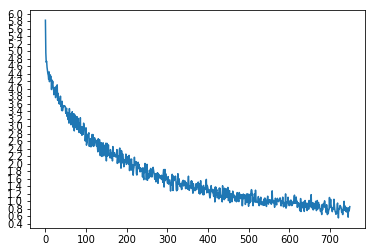

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(DEVICE)
#decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(DEVICE)

#attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(DEVICE)

#def __init__(self, hidden_size, method="dot"):
attention = Attention(hidden_size = hidden_size, method='concat')

#def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
luong_decoder1 = LuongDecoder(hidden_size, output_lang.n_words, attention=attention, drop_prob=0.1).to(DEVICE)

trainIters(encoder1, luong_decoder1, 75000, print_every=5000)

4m 9s (- 12m 29s) (5000 25%) 0.6651
8m 28s (- 8m 28s) (10000 50%) 0.6241
12m 35s (- 4m 11s) (15000 75%) 0.5936
16m 41s (- 0m 0s) (20000 100%) 0.5853


<Figure size 432x288 with 0 Axes>

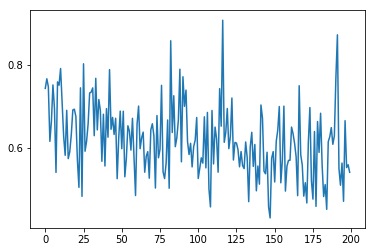

In [19]:
#Continue training
trainIters(encoder1, luong_decoder1, 20000, print_every=5000)

4m 0s (- 12m 0s) (5000 25%) 0.5173
7m 59s (- 7m 59s) (10000 50%) 0.4297
11m 47s (- 3m 55s) (15000 75%) 0.4221
15m 39s (- 0m 0s) (20000 100%) 0.4033


<Figure size 432x288 with 0 Axes>

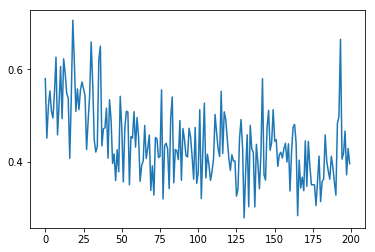

In [20]:
#Continue training
trainIters(encoder1, luong_decoder1, 20000, print_every=5000, learning_rate=0.001)

4m 18s (- 12m 55s) (5000 25%) 0.3864
8m 26s (- 8m 26s) (10000 50%) 0.3774
12m 13s (- 4m 4s) (15000 75%) 0.3735
16m 25s (- 0m 0s) (20000 100%) 0.3689


<Figure size 432x288 with 0 Axes>

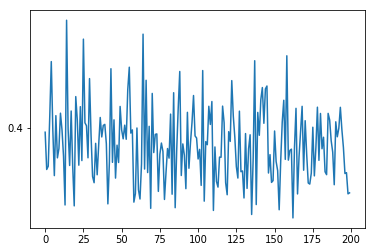

In [21]:
#Continue training
trainIters(encoder1, luong_decoder1, 20000, print_every=5000, learning_rate=0.0001)

4m 26s (- 31m 5s) (5000 12%) 0.3670
8m 48s (- 26m 24s) (10000 25%) 0.3525
13m 34s (- 22m 37s) (15000 37%) 0.3589
18m 18s (- 18m 18s) (20000 50%) 0.3735
22m 20s (- 13m 24s) (25000 62%) 0.3804
26m 25s (- 8m 48s) (30000 75%) 0.3642
30m 43s (- 4m 23s) (35000 87%) 0.3560
34m 51s (- 0m 0s) (40000 100%) 0.3455


<Figure size 432x288 with 0 Axes>

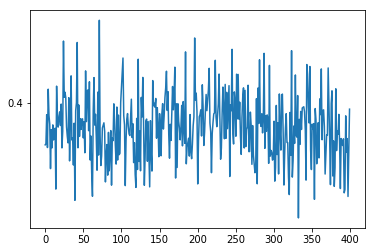

In [29]:
#Continue training
trainIters(encoder1, luong_decoder1, 40000, print_every=5000, learning_rate=0.0001)

In [23]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=DEVICE)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=DEVICE)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
                                    
            if type(decoder_attention) != type(None): #Handle simple decoder
                decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        #print(attentions)
        print('')

In [25]:
evaluateRandomly(encoder1, luong_decoder1)

> he teaches us english .
= μας μαθαινει αγγλικα .
< μας διδασκει αγγλικα . <EOS>

> who ?
= ποιος 
< ποιος  <EOS>

> it is a little cold .
= ειναι λιγο κρυο .
< ειναι λιγο κρυο . <EOS>

> did you know tom well ?
= γνωριζατε καλα τον τομ 
< γνωριζες καλα τον τομ  <EOS>

> she teaches us french .
= μας διδασκει γαλλικα .
< μας διδασκει γαλλικα . <EOS>

> are you afraid of tom ?
= φοβαστε τον τομ 
< φοβαστε τον τομ  <EOS>

> these lemons are fresh .
= αυτα τα λεμονια ειναι φρεσκα .
< αυτα τα λεμονια ειναι φρεσκα . <EOS>

> tom what do you want for supper ?
= τομ τι θες για βραδινο 
< τι τομ θες για βραδινο  <EOS>

> tom isn t ready .
= δεν ειναι ετοιμος ο τομ .
< δεν ειναι ετοιμος ο τομ . <EOS>

> i ran home .
= ετρεξα σπιτι .
< ετρεξα σπιτι . <EOS>



In [26]:
def predict(encoder, decoder, text):
    output_words, attentions = evaluate(encoder, decoder, text)
    output_sentence = ' '.join(output_words)
    print(output_sentence)

In [27]:
predict(encoder1, attn_decoder1, 'you are very well')

NameError: name 'attn_decoder1' is not defined

ειστε πολυ καλα . <EOS>


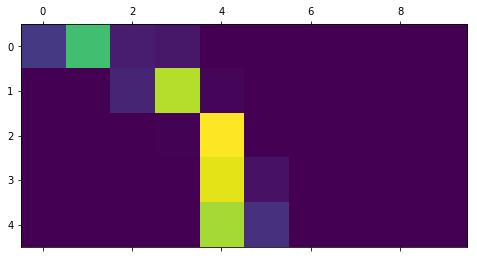

In [93]:
output_words, attentions = evaluate(
    encoder1, luong_decoder1, "you are very well .")
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.matshow(attentions.numpy())

input = you are very well
output = εισαι πολυ καλα . <EOS>


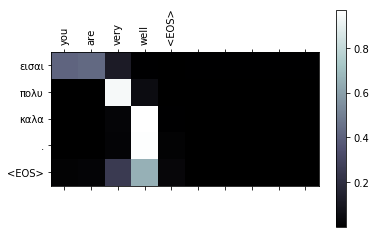

input = tom is really quiet
output = ο τομ ειναι πολυ ησυχος . <EOS>


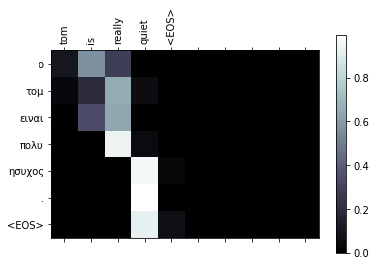

input = the first lesson is easy
output = το πρωτο μαθημα ειν ευκολο . <EOS>


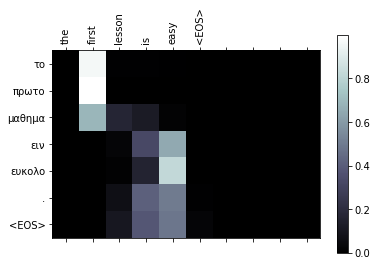

In [33]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, luong_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    #print(attentions)
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("you are very well")

evaluateAndShowAttention("tom is really quiet")

evaluateAndShowAttention("the first lesson is easy")

#evaluateAndShowAttention("c est un jeune directeur plein de talent .")